# Model Garbage Classification
Capstone Project SIB Kampus Merdeka X Dicoding.
Team ID: **CSD-114**

Datasets: [Kaggle Garbage Classification (12 classes)](https://www.kaggle.com/mostafaabla/garbage-classification)

In [1]:
!gdown https://drive.google.com/drive/folders/sdsldkfj...somefileid.. -O /some_parent_directory/some_child_directory

/usr/local/lib/python3.7/dist-packages/gdown/parse_url.py:39: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=None
  url="https://drive.google.com/uc?id={}".format(file_id)
Traceback (most recent call last):
  File "/usr/local/bin/gdown", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.7/dist-packages/gdown/cli.py", line 166, in main
    resume=args.continue_,
  File "/usr/local/lib/python3.7/dist-packages/gdown/download.py", line 202, in download
    for file in os.listdir(osp.dirname(output) or "."):
FileNotFoundError: [Errno 2] No such file or directory: '/some_parent_directory'


In [ ]:
!pip install tensorflowjs

## Importing Libraries

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

import PIL
from matplotlib import pyplot as plt

import os
import gdown
import zipfile
import pathlib

## Set up datesets

In [3]:
url = 'https://drive.google.com/uc?id=101qEIzIljJg3cQbD_7CfitrJ_O9m3J94'
output = 'garbage.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=101qEIzIljJg3cQbD_7CfitrJ_O9m3J94
To: /content/garbage.zip
100%|██████████| 251M/251M [00:03<00:00, 76.5MB/s]


'garbage.zip'

In [4]:
local_zip = '/content/garbage.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

PATH = '/content/garbage_classification'
PATH

'/content/garbage_classification'

## Load Datasets

In [5]:
data_dir = pathlib.Path(PATH)

image_count = len(list(data_dir.glob('*/*.jpg')))
print(f'Total image from this datasets : {image_count}')

Total image from this datasets : 15515


In [6]:
## check list directory datasets
print('List Class Image\n')
for i, label in enumerate(os.listdir(data_dir)):
  print(f'{i+1}. {label}')

List Class Image

1. white-glass
2. biological
3. shoes
4. metal
5. trash
6. paper
7. green-glass
8. battery
9. plastic
10. brown-glass
11. cardboard
12. clothes


# Split data

In [7]:
# Parameter for spliting
batch_size = 32
img_height = 224
img_width = 224

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15515 files belonging to 12 classes.
Using 12412 files for training.
Found 15515 files belonging to 12 classes.
Using 3103 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


In [10]:
class_names_val = val_ds.class_names
print(class_names_val)

['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


Check Image batch

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


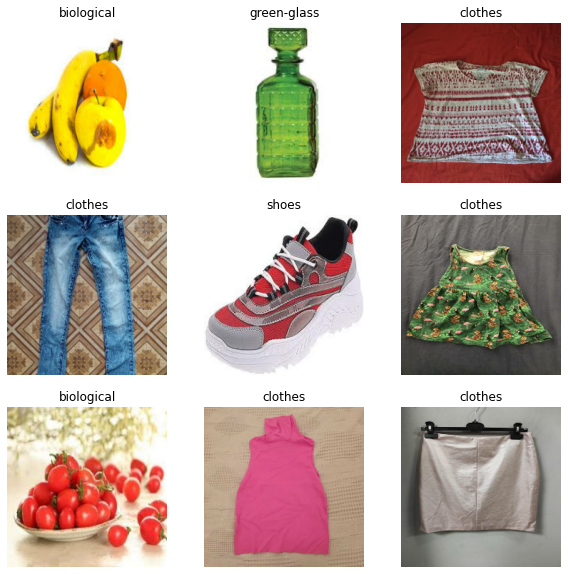

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [14]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 78
Number of test batches: 19


# Configure the dataset for performance

In [15]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

## Use Model pre-trained using TF-HUB

In [17]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_model = mobilenet_v2

In [18]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

In [19]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [20]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 12)                15372     
                                                                 
Total params: 2,273,356
Trainable params: 15,372
Non-trainable params: 2,257,984
_________________________________________________________________


In [23]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [24]:
NUM_EPOCHS = 10

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS)

Epoch 1/10
388/388 [==============================] - 65s 104ms/step - loss: 0.4244 - accuracy: 0.8779 - val_loss: 0.2400 - val_accuracy: 0.9323
Epoch 2/10
388/388 [==============================] - 36s 93ms/step - loss: 0.1661 - accuracy: 0.9509 - val_loss: 0.2152 - val_accuracy: 0.9371
Epoch 3/10
388/388 [==============================] - 36s 93ms/step - loss: 0.1215 - accuracy: 0.9646 - val_loss: 0.1961 - val_accuracy: 0.9391
Epoch 4/10
388/388 [==============================] - 36s 93ms/step - loss: 0.0932 - accuracy: 0.9734 - val_loss: 0.1919 - val_accuracy: 0.9431
Epoch 5/10
388/388 [==============================] - 36s 93ms/step - loss: 0.0753 - accuracy: 0.9804 - val_loss: 0.1993 - val_accuracy: 0.9391
Epoch 6/10
388/388 [==============================] - 36s 93ms/step - loss: 0.0605 - accuracy: 0.9853 - val_loss: 0.1961 - val_accuracy: 0.9395
Epoch 7/10
388/388 [==============================] - 36s 93ms/step - loss: 0.0490 - accuracy: 0.9894 - val_loss: 0.1959 - val_accuracy

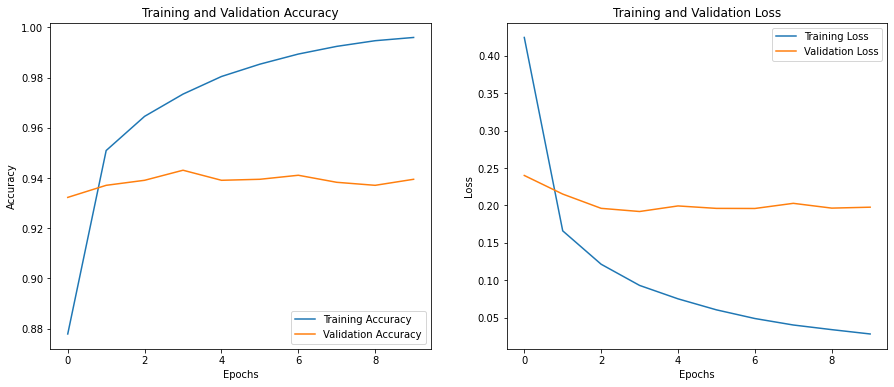

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Convet Model Into JSON

In [30]:
path_model = '/content/saved'
model.save(path_model)

INFO:tensorflow:Assets written to: /content/saved/assets


INFO:tensorflow:Assets written to: /content/saved/assets


In [31]:
!tensorflowjs_converter --input_format=tf_saved_model \
                         --output_node_names='MobilenetV3/Predictions/Reshape_1' \
                         --saved_model_tags=serve \
                         path_model \
                         ./output/saved_json

2022-05-10 08:57:11.783109: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Writing weight file ./output/saved_json/model.json...


In [35]:
import shutil
shutil.make_archive('/content/output', 'zip', '/content/output')

'/content/output.zip'

In [36]:
from google.colab import files
files.download('/content/output.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>